In [1]:
import pandas as pd
import torch
import os
import sklearn
import numpy as np
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import sys
from tqdm import tqdm
sys.path.append('./..')
sys.path.append('./../..')
from pandarallel import pandarallel
pandarallel.initialize()
import glob 
import yaml
import pickle
from scipy.special import softmax as SOFTMAX
import matplotlib.pyplot as plt
from sklearn.metrics import auc
from common_utils import utils
try:
    from common_utils import AD_result_fetcher
except:
    from .common_utils import AD_result_fetcher
from sklearn.metrics.pairwise import pairwise_distances_argmin
from time import time
from matplotlib import pyplot as plt
from sklearn.metrics import silhouette_score
from torch import nn
from torch.nn import functional as F
from torch import LongTensor as LT
from torch import FloatTensor as FT
from scipy.spatial.distance import cosine
from collections import Counter
import faiss    
from  sklearn.manifold import TSNE

INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
def obtain_bipartite_embeddings():
    global DIR
    LOC = './saved_model_data'
    _files = sorted(glob.glob(os.path.join(LOC,DIR, '**.npy')))
    emb_dict = {}
    for file in _files:
        _domain = file.split('/')[-1].split('_')[0]
        emb_dict[_domain] = np.load(file)
    return emb_dict

In [3]:
# ---------------------------------------------
# Convert the df from serial_ID to entity_ID
# ---------------------------------------------
def convert_toEntityID(target_df):
    global bipartite_domains
    serialID_map_df = utils.fetch_idMappingFile(DIR)
    serialID_entityID_dict = {}
    
    for domain in set(bipartite_domains):
        if domain not in target_df.columns : continue
        tmp =  serialID_map_df.loc[(serialID_map_df['domain'] == domain)]
        serial_id = tmp['serial_id'].values.tolist()
        entity_id = tmp['entity_id'].values.tolist()
        serialID_entityID_dict[domain] = {k:v for k,v in zip(serial_id,entity_id)}
   
    def convert_aux(val, domain):
        return serialID_entityID_dict[domain][val]
    domain_list = bipartite_domains
    for domain in tqdm(domain_list):
        target_df[domain] = target_df[domain].parallel_apply(convert_aux, args=(domain,))
    return target_df

In [4]:
# -----------------------------
# Create synthetic mapping 
# So that ids are continuous. 
# Also embeddings can be accessed using an numpy array
# -----------------------------  
def convert_to_SynID (data_df, emb_dict):
    global bipartite_domains
    global DATA_LOC
    global DIR
    
    with open(os.path.join(DATA_LOC, DIR, 'domain_dims.pkl'),'rb') as fh:
        domain_dims = pickle.load(fh)
        
    synID = 0
    cur = 0
    col_syn_id = []
    col_entity_id = []
    col_domain_names = []
    
    # ------------------
    for d in sorted(bipartite_domains):
        s = domain_dims[d]
        col_entity_id.extend(list(range(s)))
        col_domain_names.extend([d for _ in range(s)])
        tmp = np.arange(s) + cur
        tmp = tmp.tolist()
        col_syn_id.extend(tmp)
        cur += s

    data = {'domain': col_domain_names, 'entity_id': col_entity_id, 'syn_id': col_syn_id}
    synID_mapping_df = pd.DataFrame(data)

    # -------------------
    # Replace entity_id with synthetic id 
    # -------------------
    mapping_dict = {}
    for domain in sorted(set(synID_mapping_df['domain'])):
        tmp =  synID_mapping_df.loc[(synID_mapping_df['domain'] == domain)]
        syn_id = tmp['syn_id'].values.tolist()
        entity_id = tmp['entity_id'].values.tolist()
        mapping_dict[domain] = { k:v for k,v in zip(entity_id,syn_id) }
        def convert_aux(val, domain):
            return mapping_dict[domain][val]

    for domain in tqdm(bipartite_domains):
        data_df[domain] = data_df[domain].parallel_apply(convert_aux, args=(domain,))
    
    num_entities = len(synID_mapping_df)
    emb_array = np.zeros( [num_entities, emb_dict[bipartite_domains[0]].shape[-1]])
    
    for dom in bipartite_domains:
        tmp = synID_mapping_df.loc[synID_mapping_df['domain']==dom]
        synID = tmp['syn_id'].values
        entityID = tmp['entity_id'].values
        emb_array[synID] = emb_dict[dom][entityID]
        
    return data_df,  emb_array , synID_mapping_df

In [5]:
config_file = 'config.yaml'
with open(config_file,'r') as fh:
    CONFIG = yaml.safe_load(fh)

KNN = 6
WHITELIST_COUNT = 5
attr_consignee = CONFIG['attribute_CONSIGNEE'] 
attr_shipper = CONFIG['attribute_SHIPPER']
ID_COL = CONFIG['ID_COL']
DATA_LOC = CONFIG['DATA_LOC']
bipartite_domains = sorted([attr_consignee, attr_shipper])
NEG_PERCENTILE_THRESHOLD = CONFIG['NEG_PERCENTILE_THRESHOLD']
MAX_ANOM_LABELS = 15

DIR = 'us_import5'

labelled_results = AD_result_fetcher.read_in_AD_result(DIR)
ANOMALY_PERCENTILE_THRESHOLD  = CONFIG['ANOMALY_PERCENTILE_THRESHOLD']
score_threshold = np.percentile(labelled_results['score'],CONFIG['ANOMALY_PERCENTILE_THRESHOLD'])
print(CONFIG['ANOMALY_PERCENTILE_THRESHOLD'], score_threshold)
bipartite_embeddings = obtain_bipartite_embeddings()
main_df = (labelled_results[[ID_COL , 'label', 'score'] + bipartite_domains]).copy()
df1 = convert_toEntityID(main_df.copy())
data_df, emb_array , synID_mapping_df = convert_to_SynID (df1.copy(), bipartite_embeddings)

  0%|          | 0/2 [00:00<?, ?it/s]

28978 28978
95 0.6052062102358358


100%|██████████| 2/2 [00:02<00:00,  1.43s/it]


In [6]:
# -----------------------------------
# Build Nearest Neighbor Query Index
# -----------------------------------
index = faiss.IndexFlatL2(32)   # build the index
print('Building FAISS index. Index trained ? ', index.is_trained)
index.add(emb_array.astype(np.float32))                 
print(' Size of index ::', index.ntotal)

Building FAISS index. Index trained ?  True
 Size of index :: 9454


In [7]:
working_df = data_df.copy()
working_df['dynamic_score'] = working_df['score'].values
# ------------------
# Type conversion : to ensure no bugs
# ------------------
working_df['PanjivaRecordID'] = working_df['PanjivaRecordID'].astype(int)
working_df['ConsigneePanjivaID'] = working_df['ConsigneePanjivaID'].astype(int)
working_df['ShipperPanjivaID'] = working_df['ShipperPanjivaID'].astype(int)
working_df = working_df.reset_index(drop=True)

In [8]:
neg_label_cutoff_score = np.percentile(working_df['score'], 60)
df2 = working_df.loc[working_df['score'] <= neg_label_cutoff_score]
elements = df2[attr_consignee].values.tolist() + df2[attr_shipper].values.tolist()
white_list_entities = []
for k,v in Counter(elements).items(): 
    if v > WHITELIST_COUNT : 
        white_list_entities.append(k)

In [9]:
print(' # white_list_entities', len(white_list_entities))

 # white_list_entities 1317


In [10]:
def process_v1(df_cur, label_top_k):
    global attr_consignee
    global ID_COL
    global attr_shipper
    global white_list_entities
    white_list = white_list_entities
    
    print('label_top_k ',label_top_k)
    df_cur = df_cur.sort_values(by='score',ascending=False)
    min_score = np.percentile(df_cur['score'], ANOMALY_PERCENTILE_THRESHOLD)
    seen_ids = []
    count = 0
    labelled_df = None
    idx = 0

    for i,row in df_cur.iterrows():
        _id = int(row[ID_COL])
        idx = i
        seen_ids.append(_id)

        if row['label']==1: 
            count +=1
            if count > label_top_k : 
                break

    seen_ids = set(seen_ids)
    labelled_df = df_cur.iloc[:idx,:]
    unlabelled_df = df_cur.iloc[idx:,:]
    orig_target_df = unlabelled_df.copy().reset_index(drop=True)


    tmp_N = labelled_df.loc[labelled_df['label']!=1]
    tmp_P = labelled_df.loc[labelled_df['label']==1]
    neg_entities = tmp_N[attr_consignee].values.tolist() + tmp_N[attr_shipper].values.tolist()
    pos_entities = tmp_P[attr_consignee].values.tolist() + tmp_P[attr_shipper].values.tolist()
    pos_entities = list(sorted(set(pos_entities)))
    neg_entities = list(sorted(set(neg_entities)))

    print(' - / +', len(set(neg_entities)),len(set(pos_entities)) )
#     query_P = (emb_array[pos_entities]).astype(np.float32)
#     D, nn_index_P = index.search(query_P, KNN)  
#     nn_index_P = nn_index_P[:,1:]

#     query_N = (emb_array[neg_entities]).astype(np.float32)
#     D, nn_index_N = index.search(query_N, KNN)  
#     nn_index_N = nn_index_N[:,1:]


    candidates = unlabelled_df.loc[unlabelled_df['score']>=min_score ]
    candidates.loc[((candidates[attr_consignee].isin(white_list)) | (candidates[attr_shipper].isin(white_list)))]           
    # first see records where both match +
    df1 = candidates.loc[candidates[attr_consignee].isin(pos_entities) & (candidates[attr_shipper].isin(pos_entities))]
    df1.loc[:,'dynamic_score'] = 2

    # first see records where both match -
    df2 = candidates.loc[candidates[attr_consignee].isin(neg_entities) & (candidates[attr_shipper].isin(neg_entities))]
    df2.loc[:,'dynamic_score'] = 0

    # first see records where one matches -
    df3 = candidates.loc[((candidates[attr_consignee].isin(white_list)) | (candidates[attr_shipper].isin(white_list)))]
    df3.loc[:,'dynamic_score'] = 0

    # At least one matches +, and the other is not part of  -
    df5_1 = candidates.loc[(candidates[attr_consignee].isin(pos_entities)) & ~(candidates[attr_shipper].isin(neg_entities))]
    df5_2 = candidates.loc[(candidates[attr_shipper].isin(pos_entities)) & ~(candidates[attr_consignee].isin(neg_entities))]
    df_5 = pd.concat([df5_1,df5_2])
    df5 = df_5.loc[~df_5[ID_COL].isin(df1)]
    df5 = df5.loc[~df5[ID_COL].isin(df3)]
    df5.loc[:,'dynamic_score'] = 0.75

    # One of the entities has been marked negative 
    df6 = candidates.loc[(candidates[attr_shipper].isin(neg_entities)) | (candidates[attr_consignee].isin(neg_entities))]
    df6 = df6.loc[~df6[ID_COL].isin(df2)]
    df6.loc[:,'dynamic_score'] = 0.25

    id_list = df1[ID_COL].values.tolist() + df2[ID_COL].values.tolist() + df3[ID_COL].values.tolist() + df5[ID_COL].values.tolist() +  df6[ID_COL].values.tolist()
    id_list = list(set(id_list))

    df4 = candidates.loc[~candidates[ID_COL].isin(id_list)]
    df4.loc[:,'dynamic_score'] = 0.5
    df0 = pd.concat([df1,df5,df4,df6,df3,df2])
    new_df = df0
#     new_df = df0.sort_values( by = 'dynamic_score', ascending=False)
    precision_check_range = list(range(25,250+25,25))
    prec_0 = []
    prec_method = []
    
    for k in precision_check_range:
        # without input?
        top_k_target = orig_target_df.head(k)
        wo_input_precison = len(top_k_target.loc[top_k_target['label']==1])/k
        tmp =  new_df.head(k)
        correct = tmp.loc[tmp['label']==1]
        prec = len(correct)/len(tmp)
        print(' precision at next top {:3d} : {:.3f}'.format(k, prec), ' || Without input {:.3f}'.format(wo_input_precison) )
        prec_method.append(prec)
        prec_0.append(wo_input_precison)
        
    return  prec_method, prec_0


In [11]:
# process_v1(working_df.copy(), label_top_k=10)
# process_v1(working_df.copy(), label_top_k=20)
# process_v1(working_df.copy(), label_top_k=30)
# process_v1(working_df.copy(), label_top_k=40)
# process_v1(working_df.copy(), label_top_k=50)

In [12]:
def process_v2(df_cur, label_top_k):
    global attr_consignee
    global ID_COL
    global attr_shipper
    global index
    global white_list_entities
    precision_check_range = list(range(25,250+25,25))
    white_list = white_list_entities
    print('label_top_k ',label_top_k)
    df_cur = df_cur.sort_values(by='score',ascending=False)
    min_score = np.percentile(df_cur['score'], ANOMALY_PERCENTILE_THRESHOLD)
    seen_ids = []
    count = 0
    labelled_df = None
    idx = 0

    for i,row in df_cur.iterrows():
        _id = int(row[ID_COL])
        idx = i
        seen_ids.append(_id)

        if row['label']==1: 
            count +=1
            if count > label_top_k : 
                break

    seen_ids = set(seen_ids)
    labelled_df = df_cur.iloc[:idx,:]
    unlabelled_df = df_cur.iloc[idx:,:]
    orig_target_df = unlabelled_df.copy().reset_index(drop=True)

    tmp_N = labelled_df.loc[labelled_df['label']!=1]
    tmp_P = labelled_df.loc[labelled_df['label']==1]
    neg_entities = tmp_N[attr_consignee].values.tolist() + tmp_N[attr_shipper].values.tolist()
    pos_entities = tmp_P[attr_consignee].values.tolist() + tmp_P[attr_shipper].values.tolist()
    pos_entities = list(sorted(set(pos_entities)))
    neg_entities = list(sorted(set(neg_entities)))

    print(' - / +', len(set(neg_entities)),len(set(pos_entities)))
    query_P = (emb_array[pos_entities]).astype(np.float32)
    D, nn_index_P = index.search(query_P, KNN)  
    nn_index_P = nn_index_P[:,:]

    query_N = (emb_array[neg_entities]).astype(np.float32)
    D, nn_index_N = index.search(query_N, KNN)  
    nn_index_N = nn_index_N[:,:]

    candidates = unlabelled_df.loc[unlabelled_df['score']>=min_score ]
    candidates.loc[((candidates[attr_consignee].isin(white_list)) | (candidates[attr_shipper].isin(white_list)))]           
    # first see records where both match +
    df1 = candidates.loc[candidates[attr_consignee].isin(pos_entities) & (candidates[attr_shipper].isin(pos_entities))]
    df1.loc[:,'dynamic_score'] = 2

    # first see records where both match -
    df2 = candidates.loc[candidates[attr_consignee].isin(neg_entities) & (candidates[attr_shipper].isin(neg_entities))]
    df2.loc[:,'dynamic_score'] = 0

    # first see records where one matches -
    df3 = candidates.loc[((candidates[attr_consignee].isin(white_list)) | (candidates[attr_shipper].isin(white_list)))]
    df3.loc[:,'dynamic_score'] = 0
    
    # ------------------------------------------
    # df1 at top 
    # df2 + df_3 at end 
    # We use nearest neighbor based filters in the sizeable number of records in between
    # ------------------------------------------
    id_list = df1[ID_COL].values.tolist() + df2[ID_COL].values.tolist() + df3[ID_COL].values.tolist()
    id_list = list(set(id_list))
    df4 = candidates.loc[~candidates[ID_COL].isin(id_list)]  
    _P = nn_index_P[:,0].reshape(-1)
    nn_index_P = nn_index_P[:,1:].reshape(-1)
    nn_index_N = nn_index_N.reshape(-1)
    
    df4_0 = df4.loc[
        ((df4[attr_consignee].isin(pos_entities) )&(df4[attr_shipper].isin(nn_index_P)))|
        ((df4[attr_consignee].isin(nn_index_P) )&(df4[attr_shipper].isin(pos_entities)))
    ]
    
    df4 =  df4_0.loc[
        ~(df4_0[attr_consignee].isin(nn_index_N) )&(df4[attr_shipper].isin(nn_index_N))
    ]
    
    df4.loc[:,'dynamic_score'] = 0.75
    
    id_list = df1[ID_COL].values.tolist() + df2[ID_COL].values.tolist() + df3[ID_COL].values.tolist() + df4[ID_COL].values.tolist()
    df5 = candidates.loc[~candidates[ID_COL].isin(id_list)] 
    df0 = pd.concat([df1,df4,df5,df3,df2])
    new_df = df0.sort_values( by = 'dynamic_score', ascending=False)
    
    prec_0 = []
    prec_method = []
    
    for k in precision_check_range:
        # without input?
        top_k_target = orig_target_df.head(k)
        wo_input_precison = len(top_k_target.loc[top_k_target['label']==1])/k
        tmp =  new_df.head(k)
        correct = tmp.loc[tmp['label']==1]
        prec = len(correct)/len(tmp)
        print(' precision at next top {:3d} : {:.3f}'.format(k, prec), ' || Without input {:.3f}'.format(wo_input_precison) )
        prec_method.append(prec)
        prec_0.append(wo_input_precison)
    
    return prec_method, prec_0



In [13]:
df_cur = working_df.copy()

## process_v1 : Whitelist Blacklist  (multiple filters )
## process_v2 : Whitelist Blascklist  + embedding based nearest neighbor  ( LSH used)

In [14]:
res = [] 
for k in range(1,16):
    print(' ----------------- ')
    print('labelling {} positive entities and checking ...'.format(k))
    df_cur = working_df.copy()
    p1, p0 = process_v1(df_cur, label_top_k = k)
    df_cur = working_df.copy()
    p2, p0 = process_v2(df_cur, label_top_k = k)
    res.append((p1,p2,p0))

/home/ddatta/anaconda3/envs/graph1/lib/python3.7/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/home/ddatta/anaconda3/envs/graph1/lib/python3.7/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


 ----------------- 
labelling 1 positive entities and checking ...
label_top_k  1
 - / + 4 2
 precision at next top  25 : 0.840  || Without input 0.520
 precision at next top  50 : 0.820  || Without input 0.460
 precision at next top  75 : 0.800  || Without input 0.427
 precision at next top 100 : 0.840  || Without input 0.390
 precision at next top 125 : 0.824  || Without input 0.424
 precision at next top 150 : 0.833  || Without input 0.453
 precision at next top 175 : 0.800  || Without input 0.457
 precision at next top 200 : 0.800  || Without input 0.455
 precision at next top 225 : 0.800  || Without input 0.449
 precision at next top 250 : 0.800  || Without input 0.464
label_top_k  1
 - / + 4 2
 precision at next top  25 : 0.800  || Without input 0.520
 precision at next top  50 : 0.800  || Without input 0.460
 precision at next top  75 : 0.853  || Without input 0.427
 precision at next top 100 : 0.830  || Without input 0.390
 precision at next top 125 : 0.840  || Without input 0.

/home/ddatta/anaconda3/envs/graph1/lib/python3.7/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/home/ddatta/anaconda3/envs/graph1/lib/python3.7/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/home/ddatta/anaconda3/envs/graph1/lib/python3.7/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

 precision at next top  25 : 0.960  || Without input 0.520
 precision at next top  50 : 0.900  || Without input 0.440
 precision at next top  75 : 0.853  || Without input 0.400
 precision at next top 100 : 0.860  || Without input 0.390
 precision at next top 125 : 0.856  || Without input 0.424
 precision at next top 150 : 0.860  || Without input 0.447
 precision at next top 175 : 0.823  || Without input 0.457
 precision at next top 200 : 0.815  || Without input 0.455
 precision at next top 225 : 0.813  || Without input 0.458
 precision at next top 250 : 0.808  || Without input 0.460
label_top_k  3
 - / + 8 3
 precision at next top  25 : 0.840  || Without input 0.520
 precision at next top  50 : 0.840  || Without input 0.440
 precision at next top  75 : 0.867  || Without input 0.400
 precision at next top 100 : 0.840  || Without input 0.390
 precision at next top 125 : 0.848  || Without input 0.424
 precision at next top 150 : 0.820  || Without input 0.447
 precision at next top 175 : 0

/home/ddatta/anaconda3/envs/graph1/lib/python3.7/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/home/ddatta/anaconda3/envs/graph1/lib/python3.7/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


 precision at next top 200 : 0.790  || Without input 0.460
 precision at next top 225 : 0.796  || Without input 0.467
 precision at next top 250 : 0.796  || Without input 0.468
label_top_k  4
 - / + 14 5
 precision at next top  25 : 0.840  || Without input 0.560
 precision at next top  50 : 0.840  || Without input 0.480
 precision at next top  75 : 0.867  || Without input 0.413
 precision at next top 100 : 0.840  || Without input 0.400
 precision at next top 125 : 0.848  || Without input 0.440
 precision at next top 150 : 0.820  || Without input 0.453
 precision at next top 175 : 0.800  || Without input 0.457
 precision at next top 200 : 0.805  || Without input 0.460
 precision at next top 225 : 0.804  || Without input 0.467
 precision at next top 250 : 0.800  || Without input 0.468
 ----------------- 
labelling 5 positive entities and checking ...
label_top_k  5
 - / + 14 7
 precision at next top  25 : 0.960  || Without input 0.560
 precision at next top  50 : 0.860  || Without input 

/home/ddatta/anaconda3/envs/graph1/lib/python3.7/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/home/ddatta/anaconda3/envs/graph1/lib/python3.7/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/home/ddatta/anaconda3/envs/graph1/lib/python3.7/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

 precision at next top  25 : 0.920  || Without input 0.560
 precision at next top  50 : 0.840  || Without input 0.460
 precision at next top  75 : 0.880  || Without input 0.400
 precision at next top 100 : 0.850  || Without input 0.390
 precision at next top 125 : 0.848  || Without input 0.440
 precision at next top 150 : 0.820  || Without input 0.453
 precision at next top 175 : 0.800  || Without input 0.451
 precision at next top 200 : 0.805  || Without input 0.455
 precision at next top 225 : 0.804  || Without input 0.467
 precision at next top 250 : 0.800  || Without input 0.464
 ----------------- 
labelling 6 positive entities and checking ...
label_top_k  6
 - / + 18 8
 precision at next top  25 : 1.000  || Without input 0.520
 precision at next top  50 : 0.880  || Without input 0.440
 precision at next top  75 : 0.787  || Without input 0.400
 precision at next top 100 : 0.780  || Without input 0.410
 precision at next top 125 : 0.776  || Without input 0.448
 precision at next to

/home/ddatta/anaconda3/envs/graph1/lib/python3.7/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/home/ddatta/anaconda3/envs/graph1/lib/python3.7/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


  || Without input 0.448
 precision at next top 150 : 0.813  || Without input 0.453
 precision at next top 175 : 0.806  || Without input 0.463
 precision at next top 200 : 0.805  || Without input 0.455
 precision at next top 225 : 0.804  || Without input 0.471
 precision at next top 250 : 0.800  || Without input 0.460
 ----------------- 
labelling 7 positive entities and checking ...
label_top_k  7
 - / + 20 9
 precision at next top  25 : 1.000  || Without input 0.520
 precision at next top  50 : 0.900  || Without input 0.440
 precision at next top  75 : 0.827  || Without input 0.387
 precision at next top 100 : 0.810  || Without input 0.410
 precision at next top 125 : 0.792  || Without input 0.448
 precision at next top 150 : 0.793  || Without input 0.453
 precision at next top 175 : 0.777  || Without input 0.469
 precision at next top 200 : 0.780  || Without input 0.455
 precision at next top 225 : 0.787  || Without input 0.471
 precision at next top 250 : 0.756  || Without input 0.

/home/ddatta/anaconda3/envs/graph1/lib/python3.7/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/home/ddatta/anaconda3/envs/graph1/lib/python3.7/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/home/ddatta/anaconda3/envs/graph1/lib/python3.7/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

 precision at next top  25 : 1.000  || Without input 0.520
 precision at next top  50 : 0.880  || Without input 0.440
 precision at next top  75 : 0.813  || Without input 0.387
 precision at next top 100 : 0.800  || Without input 0.400
 precision at next top 125 : 0.792  || Without input 0.440
 precision at next top 150 : 0.787  || Without input 0.447
 precision at next top 175 : 0.777  || Without input 0.463
 precision at next top 200 : 0.780  || Without input 0.450
 precision at next top 225 : 0.778  || Without input 0.471
 precision at next top 250 : 0.756  || Without input 0.456
label_top_k  8
 - / + 20 9
 precision at next top  25 : 1.000  || Without input 0.520
 precision at next top  50 : 0.860  || Without input 0.440
 precision at next top  75 : 0.893  || Without input 0.387
 precision at next top 100 : 0.850  || Without input 0.400
 precision at next top 125 : 0.848  || Without input 0.440
 precision at next top 150 : 0.807  || Without input 0.447
 precision at next top 175 : 

/home/ddatta/anaconda3/envs/graph1/lib/python3.7/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/home/ddatta/anaconda3/envs/graph1/lib/python3.7/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


 precision at next top  75 : 0.853  || Without input 0.400
 precision at next top 100 : 0.810  || Without input 0.400
 precision at next top 125 : 0.800  || Without input 0.448
 precision at next top 150 : 0.813  || Without input 0.440
 precision at next top 175 : 0.811  || Without input 0.463
 precision at next top 200 : 0.805  || Without input 0.445
 precision at next top 225 : 0.800  || Without input 0.471
 precision at next top 250 : 0.792  || Without input 0.452
label_top_k  9
 - / + 22 10
 precision at next top  25 : 1.000  || Without input 0.520
 precision at next top  50 : 0.900  || Without input 0.420
 precision at next top  75 : 0.893  || Without input 0.400
 precision at next top 100 : 0.850  || Without input 0.400
 precision at next top 125 : 0.848  || Without input 0.448
 precision at next top 150 : 0.813  || Without input 0.440
 precision at next top 175 : 0.806  || Without input 0.463
 precision at next top 200 : 0.800  || Without input 0.445
 precision at next top 225 :

/home/ddatta/anaconda3/envs/graph1/lib/python3.7/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/home/ddatta/anaconda3/envs/graph1/lib/python3.7/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/home/ddatta/anaconda3/envs/graph1/lib/python3.7/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

 precision at next top  25 : 1.000  || Without input 0.480
 precision at next top  50 : 0.880  || Without input 0.420
 precision at next top  75 : 0.893  || Without input 0.387
 precision at next top 100 : 0.850  || Without input 0.400
 precision at next top 125 : 0.848  || Without input 0.456
 precision at next top 150 : 0.807  || Without input 0.447
 precision at next top 175 : 0.806  || Without input 0.457
 precision at next top 200 : 0.800  || Without input 0.445
 precision at next top 225 : 0.800  || Without input 0.471
 precision at next top 250 : 0.796  || Without input 0.456
 ----------------- 
labelling 11 positive entities and checking ...
label_top_k  11
 - / + 23 10
 precision at next top  25 : 1.000  || Without input 0.480
 precision at next top  50 : 0.900  || Without input 0.420
 precision at next top  75 : 0.853  || Without input 0.373
 precision at next top 100 : 0.810  || Without input 0.400
 precision at next top 125 : 0.800  || Without input 0.456
 precision at next

/home/ddatta/anaconda3/envs/graph1/lib/python3.7/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/home/ddatta/anaconda3/envs/graph1/lib/python3.7/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


 precision at next top  25 : 1.000  || Without input 0.480
 precision at next top  50 : 0.860  || Without input 0.420
 precision at next top  75 : 0.893  || Without input 0.373
 precision at next top 100 : 0.850  || Without input 0.400
 precision at next top 125 : 0.840  || Without input 0.456
 precision at next top 150 : 0.807  || Without input 0.447
 precision at next top 175 : 0.806  || Without input 0.457
 precision at next top 200 : 0.800  || Without input 0.445
 precision at next top 225 : 0.800  || Without input 0.471
 precision at next top 250 : 0.792  || Without input 0.456
 ----------------- 
labelling 12 positive entities and checking ...
label_top_k  12
 - / + 23 10
 precision at next top  25 : 1.000  || Without input 0.440
 precision at next top  50 : 0.900  || Without input 0.400
 precision at next top  75 : 0.840  || Without input 0.360
 precision at next top 100 : 0.800  || Without input 0.390
 precision at next top 125 : 0.792  || Without input 0.448
 precision at next

/home/ddatta/anaconda3/envs/graph1/lib/python3.7/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/home/ddatta/anaconda3/envs/graph1/lib/python3.7/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/home/ddatta/anaconda3/envs/graph1/lib/python3.7/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

 precision at next top  25 : 1.000  || Without input 0.440
 precision at next top  50 : 0.880  || Without input 0.400
 precision at next top  75 : 0.827  || Without input 0.347
 precision at next top 100 : 0.790  || Without input 0.400
 precision at next top 125 : 0.792  || Without input 0.448
 precision at next top 150 : 0.800  || Without input 0.453
 precision at next top 175 : 0.789  || Without input 0.451
 precision at next top 200 : 0.795  || Without input 0.445
 precision at next top 225 : 0.796  || Without input 0.462
 precision at next top 250 : 0.776  || Without input 0.452
label_top_k  13
 - / + 24 10
 precision at next top  25 : 1.000  || Without input 0.440
 precision at next top  50 : 0.860  || Without input 0.400
 precision at next top  75 : 0.880  || Without input 0.347
 precision at next top 100 : 0.840  || Without input 0.400
 precision at next top 125 : 0.824  || Without input 0.448
 precision at next top 150 : 0.800  || Without input 0.453
 precision at next top 175 

/home/ddatta/anaconda3/envs/graph1/lib/python3.7/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/home/ddatta/anaconda3/envs/graph1/lib/python3.7/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


 precision at next top  25 : 1.000  || Without input 0.400
 precision at next top  50 : 0.980  || Without input 0.380
 precision at next top  75 : 0.907  || Without input 0.347
 precision at next top 100 : 0.880  || Without input 0.400
 precision at next top 125 : 0.864  || Without input 0.440
 precision at next top 150 : 0.860  || Without input 0.447
 precision at next top 175 : 0.846  || Without input 0.446
 precision at next top 200 : 0.850  || Without input 0.440
 precision at next top 225 : 0.844  || Without input 0.458
 precision at next top 250 : 0.828  || Without input 0.452
label_top_k  14
 - / + 24 12
 precision at next top  25 : 1.000  || Without input 0.400
 precision at next top  50 : 0.940  || Without input 0.380
 precision at next top  75 : 0.893  || Without input 0.347
 precision at next top 100 : 0.860  || Without input 0.400
 precision at next top 125 : 0.856  || Without input 0.440
 precision at next top 150 : 0.813  || Without input 0.447
 precision at next top 175 

/home/ddatta/anaconda3/envs/graph1/lib/python3.7/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/home/ddatta/anaconda3/envs/graph1/lib/python3.7/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/home/ddatta/anaconda3/envs/graph1/lib/python3.7/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

Saving figure :  results_us_import5.png


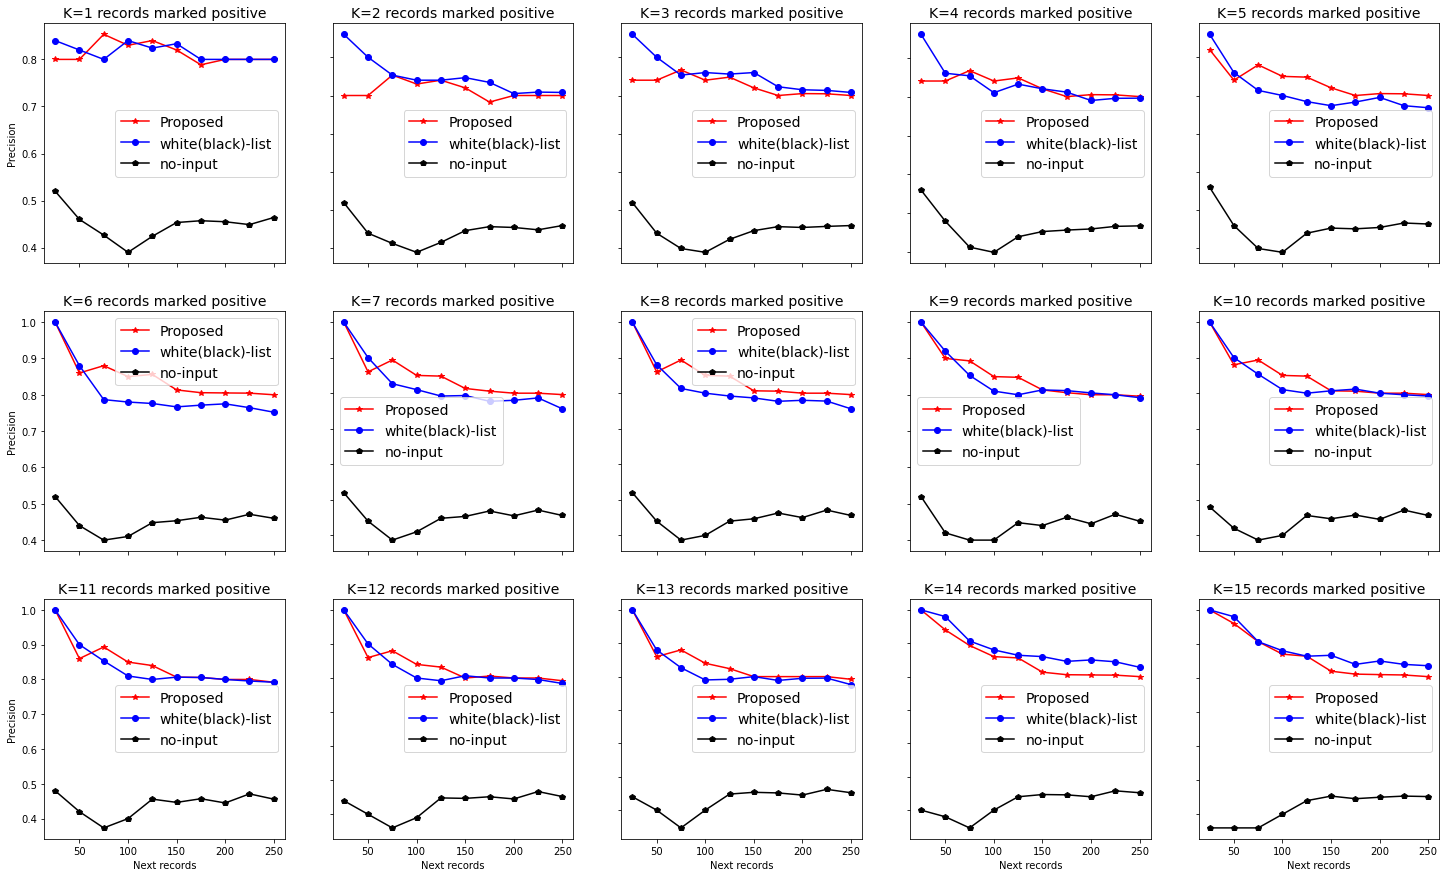

In [15]:
'''
 Cant plot in all cases !
'''
x = list(range(25,250+25,25))

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import math
num_sub_plots = MAX_ANOM_LABELS
num_cols = 5
num_rows = int(math.ceil(MAX_ANOM_LABELS/num_cols))
c = 0
r =-1
plot_idx = []
for k in range(MAX_ANOM_LABELS):
    c = c%num_cols
    if c==0: r+=1
    plot_idx.append((r,c))
    c = c+1

fig, axs = plt.subplots(r+1, c, figsize=(5*num_cols,5*(r+1)))

for k in range(0, MAX_ANOM_LABELS):
    p1,p2,p0 = res[k]
    _r = plot_idx[k][0] 
    _c = plot_idx[k][1]

    axs[_r,_c].plot(x, p2, 'r', marker='*',label='Proposed')
    axs[_r,_c].plot(x, p1, 'b', marker='o',label='white(black)-list')
    axs[_r,_c].plot(x, p0, 'k', marker='p',label='no-input')
    axs[_r,_c].legend(fontsize=14)

    axs[_r,_c].set_title('K={} records marked positive'.format(k+1),  fontsize=14)
  
    
for ax in axs.flat:
    ax.set(xlabel='Next records', ylabel='Precision')
for ax in axs.flat:
    ax.label_outer()
#     ax.set_title('Number of positive anomalies marked vs Precision in next records\n\n')
    
    
fname = 'results_{}.png'.format(DIR)
fig.savefig(fname)
print('Saving figure : ',fname)
plt.show()
plt.close()

# except:
#     pass